# Import Libraries
---
Now, we are porting XGBoost code that GPU-based code to [RAPIDS](https://rapids.ai/) on [Dask](https://docs.dask.org/en/stable/).<br/>
I hope you feel the speed increase achieved by just using RAPDIS <br/>
If you see more RAPIDS code, See my github.

<a href="https://github.com/Ign0reLee/STUDY_RAPIDS">
<img  src="https://img.shields.io/badge/github-181717?style=flat-square&logo=github&logoColor=FFFFFF" />
</a>

<a href="https://github.com/Ign0reLee/STUDY_RAPIDS">
<img  src="https://img.shields.io/badge/DASK-FC6E6B?style=flat-square&logo=dask&logoColor=FFFFFF"/>
</a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import logging
import subprocess
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections.abc import Iterator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# For GPU array computation
import cupy as cp

# For GPU dataframe operation
import cudf

# For GPU Model
from cuml.ensemble    import RandomForestClassifier as RF

# Default DASK Libraries and set use GPU's
import dask
import dask_cudf
import dask.array as da
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

# Set for Multi GPU use
from dask_cuda        import LocalCUDACluster
from dask.distributed import Client, wait, progress

# Dask Machine Learning Libraries
import dask_ml
from dask_ml.metrics         import mean_squared_error 
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV as GSCV

# Dask Model
from dask_ml.linear_mode import LogisticRegression

# For Train XGBoost
import xgboost as xgb

# For Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz


# Ready to use Multi-GPU with DASK
---

In [2]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR, silence_logs=logging.ERROR)
client = Client(cluster)

In [3]:
client

<Client: 'tcp://192.168.0.69:42629' processes=2 threads=2, memory=31.27 GiB>

# Make Timer
Check time for GPU-based libraries.

In [4]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

# Data Load
---

Dask can be used similarly to cuDF or pandas,<br/>
but it operates a bit differently, primarily running on lazy execution.<br/>
If you want to see the results of your work, you need to run it with .compute().<br/>

In [5]:
train_path = "/media/HDD2/Data/AS_Dataset/train.csv"
test_path  = "/media/HDD2/Data/AS_Dataset/test.csv"

In [6]:
with Timer("DASK"):
    train_df = dd.read_csv(train_path)
    test_df  = dd.read_csv(test_path)

DASK execute time : 0.0646 seconds


we can use persist() for move our workflow into memory

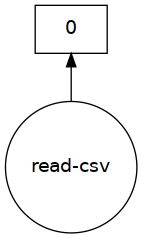

In [7]:
train_df.visualize()

In [8]:
with Timer("DASK"):
    train_df = train_df.persist()
    test_df  = test_df.persist()

DASK execute time : 0.0076 seconds


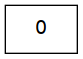

In [9]:
train_df.visualize()

In [10]:
example = train_df.compute()

In [11]:
example.head()

id  Marital status  Application mode  Application order  Course  \
0   0               1                 1                  1    9238   
1   1               1                17                  1    9238   
2   2               1                17                  2    9254   
3   3               1                 1                  3    9500   
4   4               1                 1                  2    9500   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  ...  \
0                           126.0            1                       1  ...   
1                           125.0            1                      19  ...   
2                           137.0            1                       3  ...   
3                           131.0            1                      19  ...   
4                           132.0            1                      19  ...   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    6   
1                                    0                                    6   
2                                    0                                    6   
3                                    0                                    8   
4                                    0                                    7   

   Curricular units 2nd sem (evaluations)  \
0                                       7   
1                                       9   
2                                       0   
3                                      11   
4                                      12   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    6                         12.428571   
1                                    0                          0.000000   
2                                    0                          0.000000   
3                                    7                         12.820000   
4                                    6                         12.933333   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               11.1   
1                                               0               11.1   
2                                               0               16.2   
3                                               0               11.1   
4                                               0                7.6   

   Inflation rate   GDP    Target  
0             0.6  2.02  Graduate  
1             0.6  2.02   Dropout  
2             0.3 -0.92   Dropout  
3             0.6  2.02  Enrolled  
4             2.6  0.32  Graduate  

[5 rows x 38 columns]

In [12]:
test_df.compute().head()

id  Marital status  Application mode  Application order  Course  \
0  76518               1                 1                  1    9500   
1  76519               1                 1                  1    9238   
2  76520               1                 1                  1    9238   
3  76521               1                44                  1    9147   
4  76522               1                39                  1    9670   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                      39   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  ...  \
0                           141.0            1                       3  ...   
1                           128.0            1                       1  ...   
2                           118.0            1                       1  ...   
3                           130.0            1                       1  ...   
4                           110.0            1                       1  ...   

   Curricular units 1st sem (without evaluations)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    8   
1                                    0                                    6   
2                                    0                                    6   
3                                    3                                    8   
4                                    0                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                      11   
3                                      14   
4                                       9   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.500000   
2                                    5                         11.000000   
3                                    5                         11.000000   
4                                    4                         10.666667   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               13.9   
1                                               0               11.1   
2                                               0               15.5   
3                                               0                8.9   
4                                               2                7.6   

   Inflation rate   GDP  
0            -0.3  0.79  
1             0.6  2.02  
2             2.8 -4.06  
3             1.4  3.51  
4             2.6  0.32  

[5 rows x 37 columns]

In [13]:
def LabelEncoder(ddf:dd.DataFrame)->dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        categories = ddf[c].compute().unique()
        cat2i   = {c : i for i, c in enumerate(categories.values_host)}
        i2cat   = {i : c for c, i in cat2i.items()}
        ddf[c] = ddf[c].map(cat2i)
    return ddf, i2cat

def LabelDecoder(ddf:dd.DataFrame, i2cat:dict) -> dd.DataFrame:
    ddf["Target"] = ddf["Target"].map(i2cat)
    return ddf

def StandardScaler(ddf:dd.DataFrame) -> dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        mean = ddf[c].mean()
        std  = ddf[c].std()
        ddf[c]   = (ddf[c] - mean) / std
    return ddf

In [14]:
# scaler = StandardScaler()
with Timer("DASK"):
    train_df.dropna()
    y_train, i2cat = LabelEncoder(train_df[["Target"]])
    X_train        = train_df.drop(columns=["Target", "id"])
    X_train        = StandardScaler(X_train)
    X_test         = test_df.drop(columns=["id"])

DASK execute time : 0.5553 seconds


In [15]:
X_train = X_train.persist()
y_train = y_train.persist()
X_test  = X_test.persist()

In [16]:
params = {
    'max_depth': 20,
    "verbosity": 2,
    'max_leaves':   2**8,
    'min_child_weight': 1,
    'objective':   "multi:softmax",
    'num_class' : 3,
    'grow_policy':  'lossguide',
    'eval_metric':  'auc',
    'learning_rate': 0.01,
    'tree_method':"gpu_hist",
}

with Timer("DASK"):
    dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train, enable_categorical=True)
    model =  xgb.dask.train(client, params, dtrain, num_boost_round=100)

[13:54:11] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


DASK execute time : 10.0839 seconds


In [17]:
train_out = xgb.dask.predict(client, model, dtrain)

In [18]:
train_out.compute()

array([0., 1., 1., ..., 2., 1., 0.], dtype=float32)

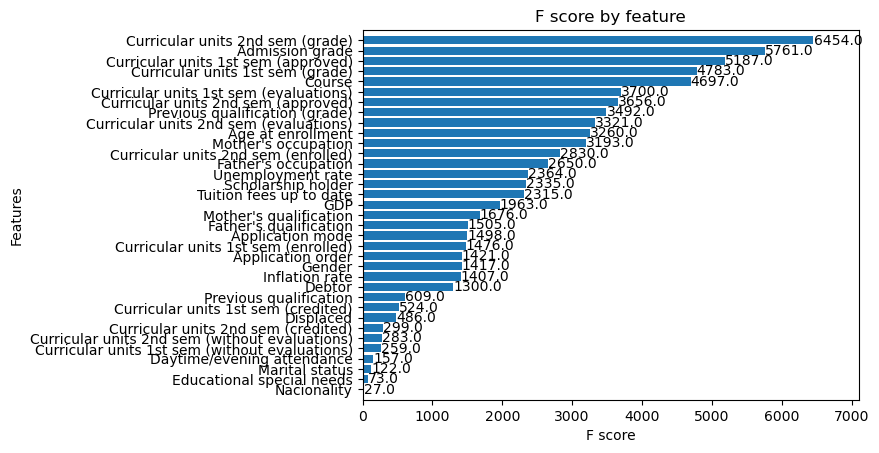

In [19]:
ax = xgb.plot_importance(model['booster'], height=.8)
ax.grid(False)
ax.set_title('F score by feature')
plt.show()

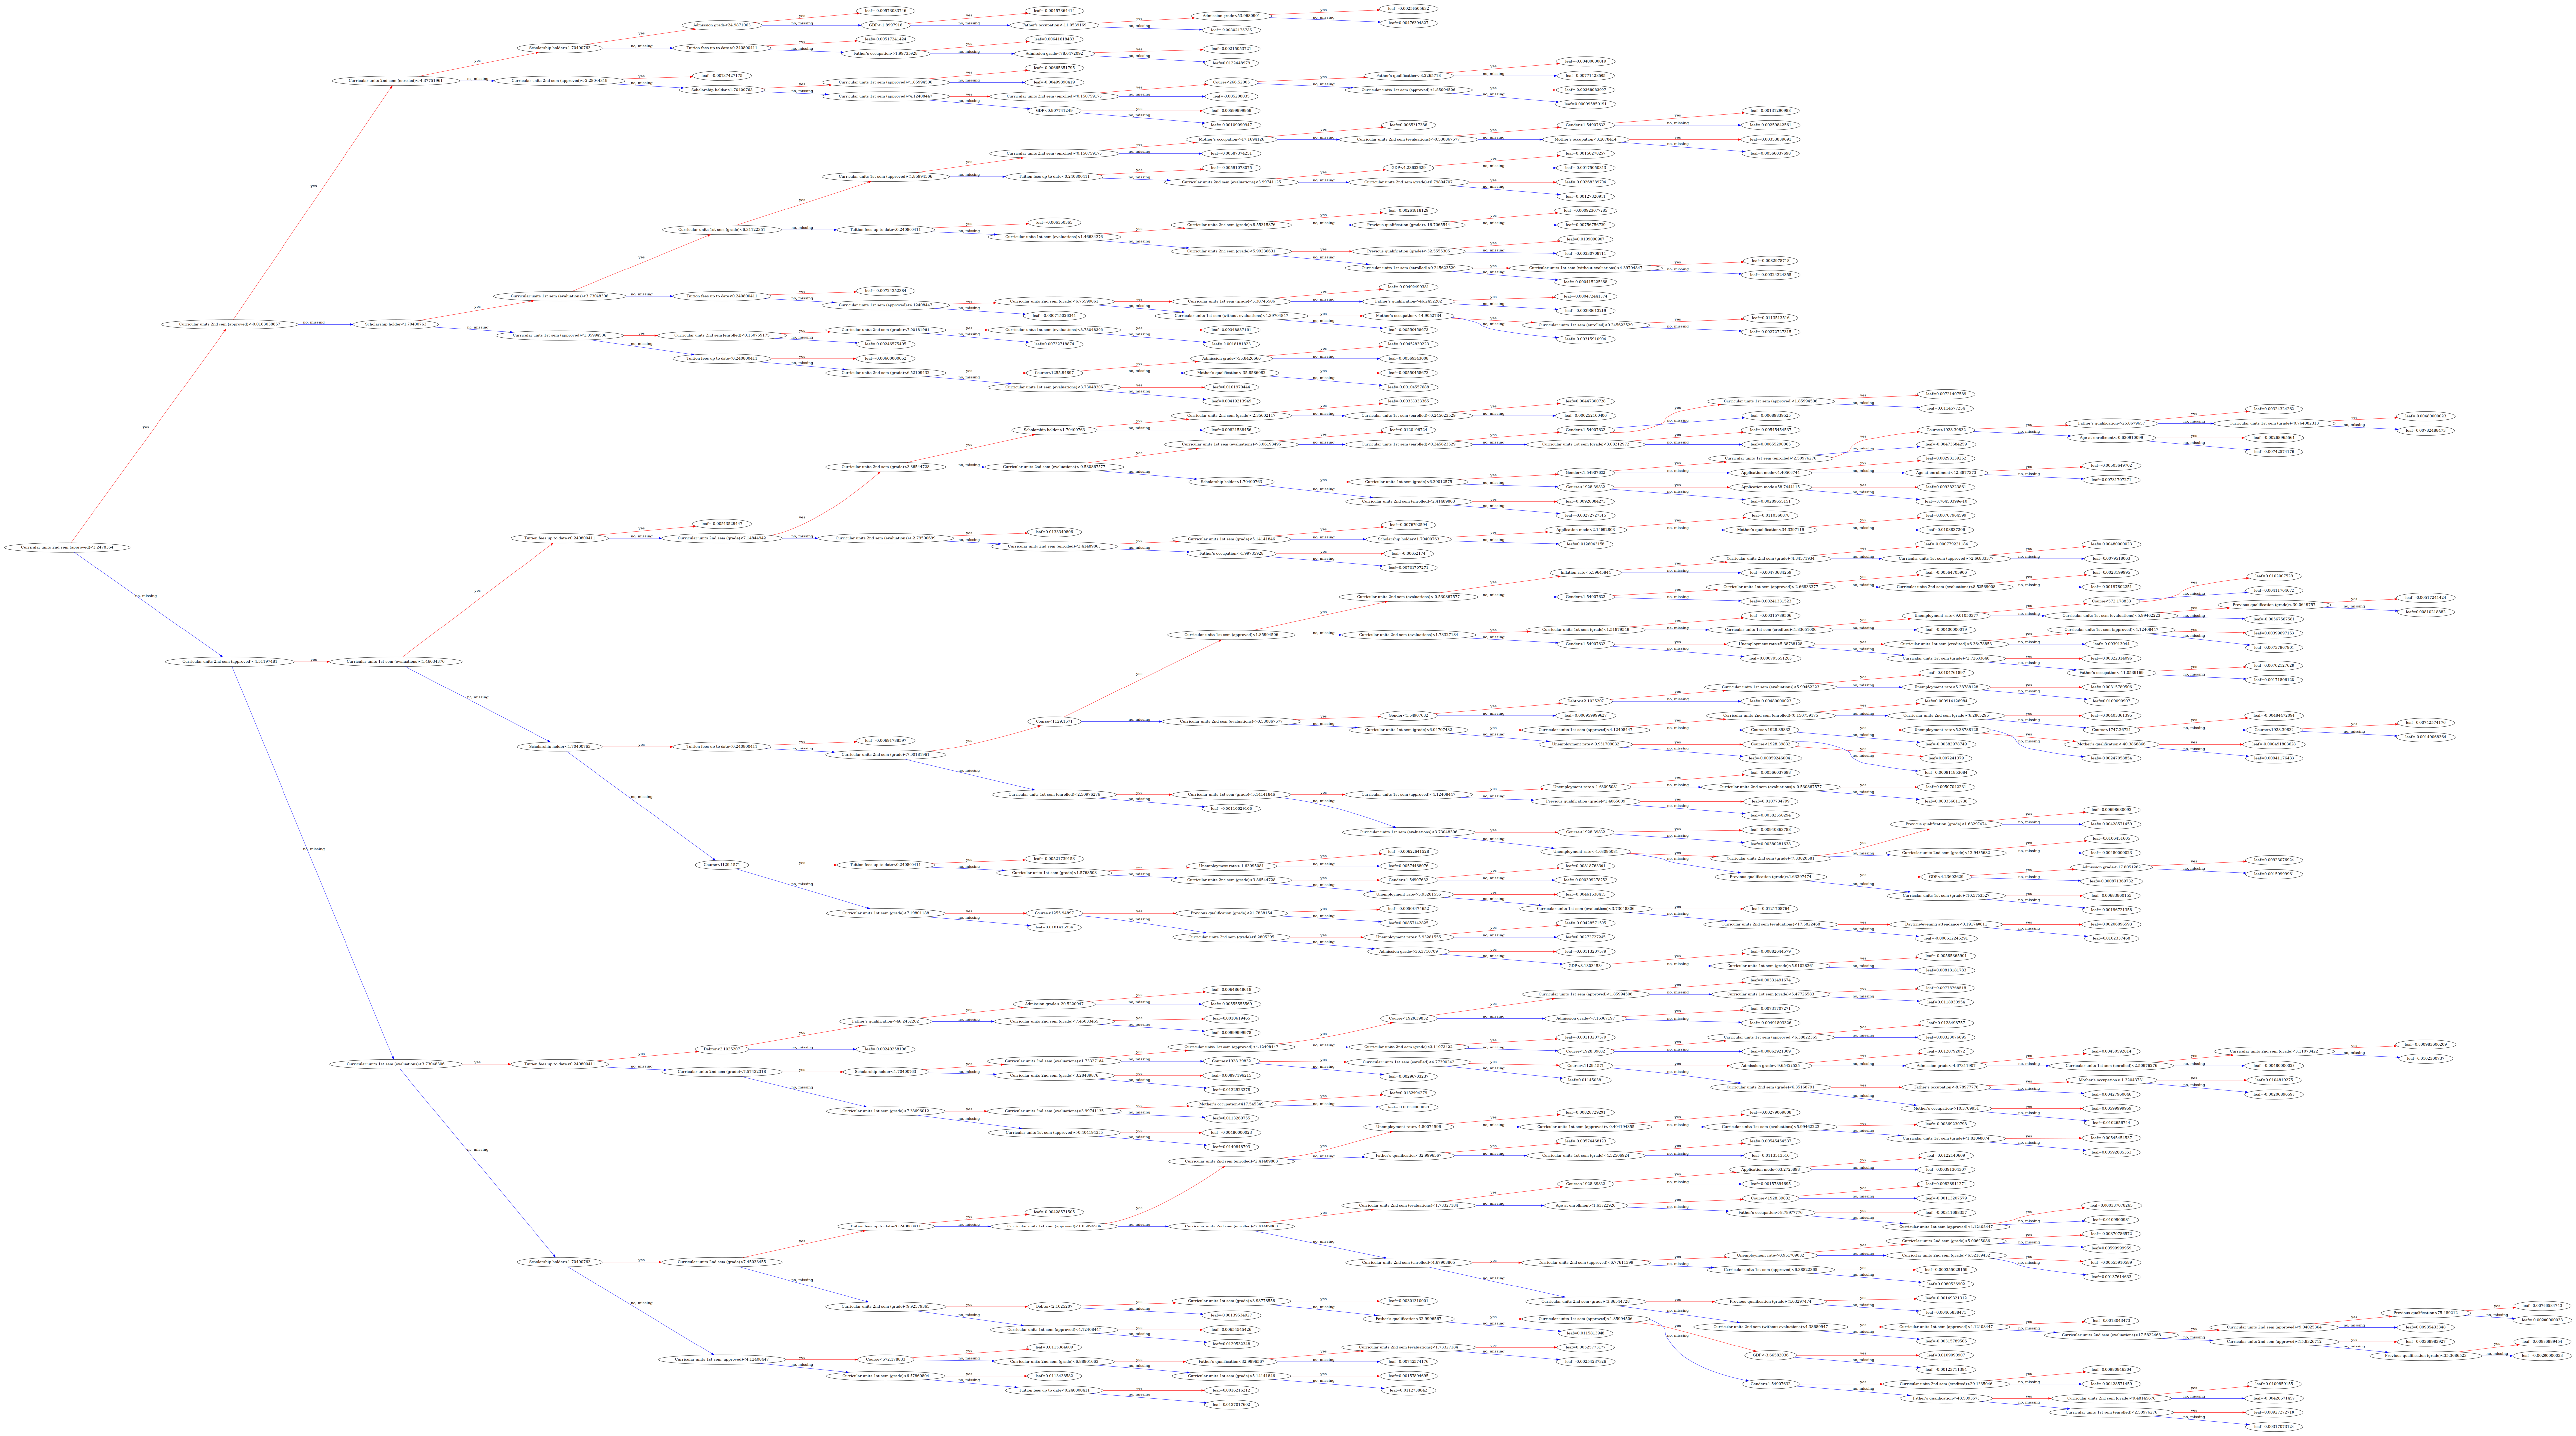

In [20]:
xgb.plot_tree(model['booster'], num_trees=0, rankdir='LR')

# get current figure to set the size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(100, 100)

In [21]:
with Timer("DASK"):
    dtest = xgb.dask.DaskDMatrix(client, X_test)
    prediction = xgb.dask.predict(client, model, dtest)

DASK execute time : 0.1283 seconds


In [22]:
pred = prediction.compute()

In [23]:
with Timer("DASK"):
    out_dd = test_df[["id"]]  
    out_dd["Target"] = prediction
    out_dd = LabelDecoder(out_dd, i2cat)
    out_dd.compute().to_csv("./submission.csv", index=False)

DASK execute time : 0.4222 seconds


# Cross Validation

In [24]:
def make_dataset(client, ddf:dd.DataFrame) -> xgb.dask.DaskDMatrix:
    if "Target" in ddf.columns:
        y, _     = LabelEncoder(ddf[["Target"]])
        X        = ddf.drop(columns=["Target", "id"])
        X        = StandardScaler(X)
        return xgb.dask.DaskDMatrix(client, X.persist(), y.persist(),  enable_categorical=True)

    else:
        X        = ddf.drop(columns=["id"]) 
        X        = StandardScaler(X)
        return xgb.dask.DaskDMatrix(client, X.persist())
    

def make_cuml_dataset(ddf:dd.DataFrame) -> dd.DataFrame:
    if "Target" in ddf.columns:
        y, _     = LabelEncoder(ddf[["Target"]])
        X        = ddf.drop(columns=["Target", "id"])

    else:
        y        = None
        X        = ddf.drop(columns=["id"]) 
    X        = StandardScaler(X)
    return X.persist(), y.persist()

def make_cv_splits(ddf:dd.DataFrame, n_folds: int = 5)-> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    splits = ddf.random_split(frac, shuffle=True)
    for i in range(n_folds):
        train = [splits[j] for j in range(n_folds) if j != i]
        test  = splits[i]
        yield dd.concat(train), test
        
def make_cv_splits_index(ddf:dd.DataFrame, n_folds: int = 5)-> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    splits = ddf.index.random_split(frac, shuffle=True)
    for i in range(n_folds):
        train_index = [splits[j] for j in range(n_folds) if j != i]
        train = [ddf[splits[j]] for j in range(n_folds) if j != i]
        test = ddf[splits[i]]
        yield dd.concat(train), test, train_index, splits[i]
        
def train_xgb(dtrain:xgb.dask.DaskDMatrix, dvalid:xgb.dask.DaskDMatrix)-> xgb.core.Booster:
    model = xgb.dask.train(client, params, dtrain, num_boost_round=100, evals=[[dtrain, 'train'],[dvalid, 'valid']])
    predict = xgb.dask.predict(client, model, dvalid)
    return model, predict

def accuracy(pred, gt):
    return ((gt == pred).astype(int).sum() / len(gt))

In [25]:
import sys

with Timer("DASK Cross Validation"):
    scores = []
    for i, (train, valid) in enumerate(make_cv_splits(train_df)):
        # Make Dataset
        dtrain = make_dataset(client, train)
        dvalid = make_dataset(client, valid)
        gt, _  = LabelEncoder(valid[["Target"]])
    
        # Train Model
        model, predict = train_xgb(dtrain, dvalid)
    
        # Make Scores
        score = accuracy(cp.array(predict), gt.to_dask_array(lengths=True).flatten())
        scores.append(score.reshape(1).persist())
    scores = da.concatenate(scores).compute()
    print(f"Acc={scores.mean()} +/- {scores.std()}")


[0]	train-auc:0.94313	valid-auc:0.83052


[13:54:48] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


[1]	train-auc:0.94337	valid-auc:0.83073
[2]	train-auc:0.94344	valid-auc:0.83075
[3]	train-auc:0.94354	valid-auc:0.83075
[4]	train-auc:0.94363	valid-auc:0.83066
[5]	train-auc:0.94376	valid-auc:0.83072
[6]	train-auc:0.94407	valid-auc:0.83330
[7]	train-auc:0.94432	valid-auc:0.83419
[8]	train-auc:0.94453	valid-auc:0.83541
[9]	train-auc:0.94470	valid-auc:0.83591
[10]	train-auc:0.94479	valid-auc:0.83603
[11]	train-auc:0.94498	valid-auc:0.83678
[12]	train-auc:0.94509	valid-auc:0.83819
[13]	train-auc:0.94527	valid-auc:0.83813
[14]	train-auc:0.94535	valid-auc:0.84117
[15]	train-auc:0.94552	valid-auc:0.84158
[16]	train-auc:0.94560	valid-auc:0.84301
[17]	train-auc:0.94571	valid-auc:0.84296
[18]	train-auc:0.94584	valid-auc:0.84446
[19]	train-auc:0.94589	valid-auc:0.84446
[20]	train-auc:0.94601	valid-auc:0.84542
[21]	train-auc:0.94609	valid-auc:0.84513
[22]	train-auc:0.94620	valid-auc:0.84524
[23]	train-auc:0.94627	valid-auc:0.84625
[24]	train-auc:0.94635	valid-auc:0.84676
[25]	train-auc:0.94646	va

[13:55:01] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


[1]	train-auc:0.94305	valid-auc:0.91370
[2]	train-auc:0.94319	valid-auc:0.91410
[3]	train-auc:0.94363	valid-auc:0.91517
[4]	train-auc:0.94367	valid-auc:0.91550
[5]	train-auc:0.94383	valid-auc:0.91576
[6]	train-auc:0.94395	valid-auc:0.91576
[7]	train-auc:0.94402	valid-auc:0.91605
[8]	train-auc:0.94413	valid-auc:0.91618
[9]	train-auc:0.94423	valid-auc:0.91647
[10]	train-auc:0.94430	valid-auc:0.91656
[11]	train-auc:0.94445	valid-auc:0.91666
[12]	train-auc:0.94456	valid-auc:0.91689
[13]	train-auc:0.94469	valid-auc:0.91692
[14]	train-auc:0.94479	valid-auc:0.91698
[15]	train-auc:0.94494	valid-auc:0.91708
[16]	train-auc:0.94504	valid-auc:0.91722
[17]	train-auc:0.94519	valid-auc:0.91726
[18]	train-auc:0.94528	valid-auc:0.91736
[19]	train-auc:0.94538	valid-auc:0.91747
[20]	train-auc:0.94548	valid-auc:0.91758
[21]	train-auc:0.94554	valid-auc:0.91776
[22]	train-auc:0.94569	valid-auc:0.91789
[23]	train-auc:0.94575	valid-auc:0.91806
[24]	train-auc:0.94585	valid-auc:0.91817
[25]	train-auc:0.94593	va

[13:55:15] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


[1]	train-auc:0.94306	valid-auc:0.82176
[2]	train-auc:0.94327	valid-auc:0.82542
[3]	train-auc:0.94394	valid-auc:0.83140
[4]	train-auc:0.94428	valid-auc:0.83228
[5]	train-auc:0.94454	valid-auc:0.83345
[6]	train-auc:0.94461	valid-auc:0.83462
[7]	train-auc:0.94468	valid-auc:0.83565
[8]	train-auc:0.94480	valid-auc:0.83504
[9]	train-auc:0.94482	valid-auc:0.83536
[10]	train-auc:0.94489	valid-auc:0.83556
[11]	train-auc:0.94495	valid-auc:0.83551
[12]	train-auc:0.94500	valid-auc:0.83561
[13]	train-auc:0.94508	valid-auc:0.83630
[14]	train-auc:0.94516	valid-auc:0.83577
[15]	train-auc:0.94525	valid-auc:0.83598
[16]	train-auc:0.94538	valid-auc:0.83781
[17]	train-auc:0.94549	valid-auc:0.83776
[18]	train-auc:0.94560	valid-auc:0.83817
[19]	train-auc:0.94571	valid-auc:0.83949
[20]	train-auc:0.94580	valid-auc:0.83923
[21]	train-auc:0.94591	valid-auc:0.83896
[22]	train-auc:0.94599	valid-auc:0.84096
[23]	train-auc:0.94608	valid-auc:0.84096
[24]	train-auc:0.94619	valid-auc:0.84225
[25]	train-auc:0.94630	va

[13:55:28] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


[1]	train-auc:0.94391	valid-auc:0.22817
[2]	train-auc:0.94403	valid-auc:0.22887
[3]	train-auc:0.94433	valid-auc:0.22833
[4]	train-auc:0.94445	valid-auc:0.23239
[5]	train-auc:0.94472	valid-auc:0.23218
[6]	train-auc:0.94503	valid-auc:0.23114
[7]	train-auc:0.94530	valid-auc:0.23112
[8]	train-auc:0.94556	valid-auc:0.22715
[9]	train-auc:0.94574	valid-auc:0.22989
[10]	train-auc:0.94584	valid-auc:0.22617
[11]	train-auc:0.94602	valid-auc:0.22605
[12]	train-auc:0.94609	valid-auc:0.22848
[13]	train-auc:0.94641	valid-auc:0.22632
[14]	train-auc:0.94656	valid-auc:0.22520
[15]	train-auc:0.94669	valid-auc:0.22407
[16]	train-auc:0.94683	valid-auc:0.22391
[17]	train-auc:0.94692	valid-auc:0.22193
[18]	train-auc:0.94705	valid-auc:0.22140
[19]	train-auc:0.94718	valid-auc:0.22049
[20]	train-auc:0.94727	valid-auc:0.21927
[21]	train-auc:0.94742	valid-auc:0.21780
[22]	train-auc:0.94752	valid-auc:0.21631
[23]	train-auc:0.94761	valid-auc:0.21533
[24]	train-auc:0.94776	valid-auc:0.21431
[25]	train-auc:0.94785	va

[13:55:41] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


[1]	train-auc:0.94413	valid-auc:0.24752
[2]	train-auc:0.94433	valid-auc:0.24738
[3]	train-auc:0.94446	valid-auc:0.24690
[4]	train-auc:0.94458	valid-auc:0.24663
[5]	train-auc:0.94466	valid-auc:0.24635
[6]	train-auc:0.94518	valid-auc:0.24567
[7]	train-auc:0.94547	valid-auc:0.24513
[8]	train-auc:0.94564	valid-auc:0.24473
[9]	train-auc:0.94576	valid-auc:0.24421
[10]	train-auc:0.94601	valid-auc:0.24346
[11]	train-auc:0.94618	valid-auc:0.24304
[12]	train-auc:0.94635	valid-auc:0.24244
[13]	train-auc:0.94650	valid-auc:0.24206
[14]	train-auc:0.94662	valid-auc:0.24151
[15]	train-auc:0.94671	valid-auc:0.24131
[16]	train-auc:0.94678	valid-auc:0.24090
[17]	train-auc:0.94684	valid-auc:0.24062
[18]	train-auc:0.94690	valid-auc:0.24045
[19]	train-auc:0.94698	valid-auc:0.24027
[20]	train-auc:0.94705	valid-auc:0.24023
[21]	train-auc:0.94714	valid-auc:0.24013
[22]	train-auc:0.94721	valid-auc:0.24010
[23]	train-auc:0.94735	valid-auc:0.23998
[24]	train-auc:0.94745	valid-auc:0.23987
[25]	train-auc:0.94761	va

# Grid Serach

In [26]:
class XGB_GridSearchCV(object):
    def __init__(self, client, params, param_groups, cv=3, num_boost_round=100, early_stopping_rounds=30):       
        self.client          = client
        self.cv              = cv
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds =  early_stopping_rounds

    
        self.make_param_set(params, param_groups)

    def fit(self, dask_df:dd.DataFrame):
        self.best_model = None
        self.best_acc   = 0
        self.best_param = {}

        for self.params in self.param_lst:
            scores = []
            for i, (train, valid) in enumerate(make_cv_splits(dask_df)):
                # Make Dataset
                dtrain = make_dataset(self.client, train)
                dvalid = make_dataset(self.client, valid)
                gt, _  = LabelEncoder(valid[["Target"]])
            
                # Train Model
                model, train_valid, pred_valid = self.train_xgb(dtrain, dvalid)
            
                # Make Scores
                score = self.accuracy(cp.array(pred_valid), gt.to_dask_array(lengths=True).flatten())
                scores.append(score.reshape(1).persist())
    
            # Check Accuracy
            scores = da.concatenate(scores).compute().mean()
            print(f"{self.params} score : {scores}")
            if scores.item() > self.best_acc:
                self.best_acc   = scores.copy()
                self.best_model = model.copy()
                self.best_param = self.params.copy()

    def make_param_set(self, params, param_gird):
        self.param_lst = [params]
        for n, p_lst in param_grid.items():
            now_lst = []
            for s in self.param_lst:
                for p in p_lst:
                    s[n] = p
                    now_lst.append(s.copy())        
            self.param_lst = now_lst.copy()
            

    def train_xgb(self, dtrain:xgb.dask.DaskDMatrix, dvalid:xgb.dask.DaskDMatrix=None)-> xgb.core.Booster:
        model = xgb.dask.train(self.client, self.params, dtrain,
                               num_boost_round=self.num_boost_round)
        train_pred = xgb.dask.predict(self.client, model, dtrain)
        valid_pred = xgb.dask.predict(self.client, model, dvalid)
        return model, train_pred, valid_pred

    def accuracy(self, pred, gt):
        return ((gt == pred).astype(int).sum() / len(gt))
        

In [27]:
params = {
     'verbosity': 2,
     'objective': 'multi:softmax',
     'num_class': 3,
     'grow_policy': 'lossguide',
     'learning_rate': 0.001,
     'max_leaves': 64,
     'max_depth': 6,
     'eval_metric': 'auc',
     'tree_method': 'gpu_hist',
     'min_child_weight': 7,
     'colsample_bytree': 0.5
}
param_grid = {
    "eval_metric" : ["auc", "merror"],
}

In [28]:
grid_search = XGB_GridSearchCV(client, params, param_grid)
grid_search.fit(train_df)

[13:55:54] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:00] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:06] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:11] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:17] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


{'verbosity': 2, 'objective': 'multi:softmax', 'num_class': 3, 'grow_policy': 'lossguide', 'learning_rate': 0.001, 'max_leaves': 64, 'max_depth': 6, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'min_child_weight': 7, 'colsample_bytree': 0.5} score : 0.5031576044665537


[13:56:23] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:29] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:35] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:40] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0
[13:56:46] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


{'verbosity': 2, 'objective': 'multi:softmax', 'num_class': 3, 'grow_policy': 'lossguide', 'learning_rate': 0.001, 'max_leaves': 64, 'max_depth': 6, 'eval_metric': 'merror', 'tree_method': 'gpu_hist', 'min_child_weight': 7, 'colsample_bytree': 0.5} score : 0.5031576044665537


In [29]:
grid_search.best_param

{'verbosity': 2,
 'objective': 'multi:softmax',
 'num_class': 3,
 'grow_policy': 'lossguide',
 'learning_rate': 0.001,
 'max_leaves': 64,
 'max_depth': 6,
 'eval_metric': 'auc',
 'tree_method': 'gpu_hist',
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [30]:
X_test[dd.concat(X_test.index.random_split([0.8, 0.2]))]

ValueError: Not all divisions are known, can't align partitions. Please use `set_index` to set the index.

In [31]:
with Timer("DASK"):
    X_test         = test_df.drop(columns=["id"])
    X_test         = StandardScaler(X_test)

X_test.persist()
    
params = {
    'verbosity': 2,
    'objective': 'multi:softmax',
    'num_class': 3,
    'grow_policy': 'lossguide',
    'learning_rate': 0.001,
    'max_leaves': 64,
    'max_depth': 6,
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'min_child_weight': 7,
    'colsample_bytree': 0.5,
    'lambda': 0.5,
    'alpha': 1
}

dtrain = make_dataset(client, train_df)
gt, _  = LabelEncoder(train_df[["Target"]])

# Train Model
model = xgb.dask.train(client, params, dtrain, num_boost_round=100, evals=[[dtrain, 'train']])
predict = xgb.dask.predict(client, model, dtrain)

# Make Scores
score = accuracy(cp.array(predict), gt.to_dask_array(lengths=True).flatten())
score.reshape(1).compute()

DASK execute time : 0.4034 seconds
[0]	train-auc:0.92623
[1]	train-auc:0.92805
[2]	train-auc:0.93297
[3]	train-auc:0.93343
[4]	train-auc:0.93276
[5]	train-auc:0.93356
[6]	train-auc:0.93371
[7]	train-auc:0.93401


[13:57:03] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


[8]	train-auc:0.93455
[9]	train-auc:0.93439
[10]	train-auc:0.93445
[11]	train-auc:0.93415
[12]	train-auc:0.93411
[13]	train-auc:0.93413
[14]	train-auc:0.93478
[15]	train-auc:0.93510
[16]	train-auc:0.93522
[17]	train-auc:0.93550
[18]	train-auc:0.93549
[19]	train-auc:0.93558
[20]	train-auc:0.93575
[21]	train-auc:0.93589
[22]	train-auc:0.93600
[23]	train-auc:0.93611
[24]	train-auc:0.93622
[25]	train-auc:0.93624
[26]	train-auc:0.93628
[27]	train-auc:0.93637
[28]	train-auc:0.93648
[29]	train-auc:0.93641
[30]	train-auc:0.93639
[31]	train-auc:0.93642
[32]	train-auc:0.93645
[33]	train-auc:0.93646
[34]	train-auc:0.93645
[35]	train-auc:0.93649
[36]	train-auc:0.93655
[37]	train-auc:0.93662
[38]	train-auc:0.93656
[39]	train-auc:0.93649
[40]	train-auc:0.93646
[41]	train-auc:0.93645
[42]	train-auc:0.93648
[43]	train-auc:0.93650
[44]	train-auc:0.93651
[45]	train-auc:0.93651
[46]	train-auc:0.93651
[47]	train-auc:0.93656
[48]	train-auc:0.93661
[49]	train-auc:0.93663
[50]	train-auc:0.93666
[51]	train-au

array([0.82073499])

In [32]:

type(predict.compute())

numpy.ndarray

In [33]:
dtest = xgb.dask.DaskDMatrix(client, X_test)
prediction = xgb.dask.predict(client, model, dtest)
pred = prediction.compute()

In [34]:
sim(cudf.Series(prediction))

NameError: name 'sim' is not defined

In [35]:
with Timer("DASK"):
    out_dd = test_df[["id"]]  
    out_dd["Target"] = prediction
    out_dd = LabelDecoder(out_dd, i2cat)
    out_dd.compute().to_csv("./submission.csv", index=False)

DASK execute time : 0.0603 seconds


# Stacking Model

In [ ]:
'Course' in (next(make_cv_splits_index(X_test))[0].columns)

In [ ]:
X_train.categorize().compute().head().astype(cp.float32)

In [ ]:
class StackingModels(object):
    def __init__(self, client, params, cv=3, num_boost_round=100, early_stopping_rounds=30):       
        self.client          = client
        self.params          = params
        self.cv              = cv
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds =  early_stopping_rounds

    def fit(self, train_df:dd.DataFrame, test_df:dd.DataFrame):

        #Make save pred
        self.train_fold_pred = cp.empty([])
        self.train_fold_gt   = cp.empty([])
        self.test_fold_pred  = cp.zeros([len(test_df), self.cv])
        dtest     = make_dataset(self.client,test_df)
        X_test, _ = make_cuml_dataset(test_df)
        
        # K_Fold XGB
        scores = []
        for i, (train, valid ) in enumerate(make_cv_splits(train_df, self.cv)):
            # Make Dataset
            dtrain = make_dataset(self.client, train)
            dvalid = make_dataset(self.client, valid)
            X_train, y_train = make_cuml_dataset(test_df)
            X_valid, y_valid = make_cuml_dataset(test_df)
            gt, _  = LabelEncoder(valid[["Target"]])
            
            # Train XGB Model
            model, train_valid, pred_valid = self.train_xgb(dtrain, dvalid)
            
            # Make Scores
            score = self.accuracy(cp.array(pred_valid), gt.to_dask_array(lengths=True).flatten())
            scores.append(score.reshape(1).persist())

            # Train Random Forest            
            model = RF(n_estimators=self.num_boost_round, max_depth=6)
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid.compute())
            
            
            
            self.train_fold_pred = cp.append(self.train_fold_pred, cp.array(pred_valid))
            self.train_fold_gt   = cp.append(self.train_fold_gt, cp.array(gt.compute()["Target"]))

            self.test_fold_pred[:, i] = cp.array(xgb.dask.predict(self.client, model, dtest)) 
        
            
        scores = da.concatenate(scores).compute().mean()
        print(f"{self.params} score : {scores}")
        
    
            
    def train_xgb(self, dtrain:xgb.dask.DaskDMatrix, dvalid:xgb.dask.DaskDMatrix=None)-> xgb.core.Booster:
        model = xgb.dask.train(self.client, self.params, dtrain,
                               num_boost_round=self.num_boost_round)
        train_pred = xgb.dask.predict(self.client, model, dtrain)
        valid_pred = xgb.dask.predict(self.client, model, dvalid)
        return model, train_pred, valid_pred

    def accuracy(self, pred, gt):
        return ((gt == pred).astype(int).sum() / len(gt))

In [ ]:
Stack = StackingModels(client, params)

In [ ]:
Stack.fit(train_df, test_df)

In [ ]:
Stack.train_fold_pred.shape

In [36]:
with Timer("DASK"):
    train_df.dropna()
    y_train, i2cat = LabelEncoder(train_df[["Target"]])
    X_train        = train_df.drop(columns=["Target", "id"])
    X_train        = StandardScaler(X_train)
    X_test         = test_df.drop(columns=["id"])
    
X_train = X_train.persist()
X_test  = X_test.persist()
y_train = y_train["Target"].persist()

model = RF(n_estimators=200, max_depth=10, n_streams=1)
model.fit(X_train, y_train)

DASK execute time : 0.4474 seconds


RandomForestClassifier()

In [37]:
prediction = model.predict(X_train.compute())

In [38]:
prediction = model.predict(X_test.compute())
with Timer("DASK"):
    out_dd = test_df[["id"]]  
    out_dd["Target"] = da.array(prediction)
    out_dd = LabelDecoder(out_dd, i2cat)
    out_dd.compute().to_csv("./submission.csv", index=False)

DASK execute time : 0.0799 seconds


In [40]:
model = xgb.dask.DaskXGBClassifier()
model.fit(X_train, y_train)

[13:57:37] task [xgboost.dask-1]:tcp://192.168.0.69:45555 got new rank 0


DaskXGBClassifier(objective='multi:softprob')

In [ ]:
sim(prediction)

# Similarity to XGB + LGBM

In [ ]:
gt = dd.read_csv("./gt.csv")
gt, _ = LabelEncoder(gt[["Target"]])

In [ ]:
da.array(prediction).compute()

In [ ]:
gt.to_dask_array(lengths=True).flatten().compute()

In [ ]:
(da.array(cudf.Series(prediction)) == gt.to_dask_array(lengths=True).flatten()).astype(int).compute()

In [ ]:
def sim(prediction):
    gt = dd.read_csv("./gt.csv")
    gt, _ = LabelEncoder(gt[["Target"]])
    gt.to_dask_array().compute().flatten()
    print((((da.array(prediction) == gt.to_dask_array(lengths=True).flatten()).astype(int))).compute().values.sum()/len(gt))

In [ ]:
sim()